In [1]:
# # Associate Ca2+ signal with cheeseboard position for each session & subsessions using crossregistration

#######################################################################################
                            # Define Experiment type #
#######################################################################################

AnalysisID='test' 

saveexcel=0

all_expe_types =['Cheeseboard']

dir = "//10.69.168.1/crnldata/forgetting/Aurelie/MiniscopeOE_data/L2_3_mice/YL/PlaceCells_experiment/"

In [2]:
cd "C:/Users/Manip2/SCRIPTS/minian/"

C:\Users\Manip2\SCRIPTS\minian


In [28]:
#######################################################################################
                                # Load packages #
#######################################################################################

import os
import numpy as np
from scipy import signal
import quantities as pq
import math 
import neo
import json
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
import pickle
import sys 
from datetime import datetime
import shutil
from ast import literal_eval
from scipy.signal import find_peaks
from scipy.stats import zscore
from scipy import stats
from itertools import groupby
from IPython.display import display
from scipy.interpolate import griddata
import numpy as np
from scipy.signal import butter, filtfilt, hilbert
import matplotlib.pyplot as plt
from scipy import interpolate
import numpy.matlib
from sklearn.decomposition import PCA
from scipy import stats
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import resample
from scipy.signal import resample_poly
from math import gcd
import warnings
warnings.filterwarnings("ignore")
import sys
from scipy.interpolate import interp1d
from collections import defaultdict
import bisect
from scipy.ndimage import gaussian_filter
import random
class Tee:
    def __init__(self, *files):
        self.files = files
    def write(self, obj):
        for f in self.files:
            f.write(obj)
            f.flush()
    def flush(self):
        for f in self.files:
            f.flush()


minian_path = os.path.join(os.path.abspath('.'),'minian')
print("The folder used for minian procedures is : {}".format(minian_path))
sys.path.append(minian_path)

from minian.utilities import (
    TaskAnnotation,
    get_optimal_chk,
    load_videos,
    open_minian,
    save_minian,
)

The folder used for minian procedures is : C:\Users\Manip2\SCRIPTS\minian\minian


In [4]:
# Define parameters & functions
pixel_to_cm = 2.25  
table_center_x, table_center_y = 313, 283  # Center of the cheeseboard table on the video
table_center_x, table_center_y = 300, 270  # Center of the cheeseboard table on the video
table_radius = 290 / 2
square_size = pixel_to_cm * 6

In [5]:
#######################################################################################
                                # Define functions #
#######################################################################################

def remove_outliers_avg_filter(data):
    data = np.array(data, dtype=float)  # Ensure NumPy array with float type
    filtered_data = np.copy(data)  # Copy to avoid modifying original data
    for i in range(len(data)):
        if not np.isnan(data[i]):  # Skip valid values
            continue
        # Find the closest previous non-NaN value
        prev_idx = i - 1
        while prev_idx >= 0 and np.isnan(data[prev_idx]):
            prev_idx -= 1        
        # Find the closest next non-NaN value
        next_idx = i + 1
        while next_idx < len(data) and np.isnan(data[next_idx]):
            next_idx += 1
        # Compute average if both values exist
        if prev_idx >= 0 and next_idx < len(data):
            filtered_data[i] = (data[prev_idx] + data[next_idx]) / 2
        # If neither exists, NaN remains
    return filtered_data

def find_closest_index_sorted(arr, target):
    idx = bisect.bisect_left(arr, target)  # Find the insertion point
    if idx == 0:
        return 0
    if idx == len(arr):
        return len(arr) - 1
    before = idx - 1
    after = idx
    return before if abs(arr[before] - target) <= abs(arr[after] - target) else after

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

def detect_longest_lowest_sequence(arr, margin=0):
    min_val = np.nanmin(arr)  # Find minimum value
    threshold = min_val + margin  # Define threshold based on margin    
    # Get indices where values are within the threshold
    min_indices = np.where(arr <= threshold)[0]
    # Identify consecutive sequences
    longest_sequence = None
    if len(min_indices) > 0:
        start = min_indices[0]
        max_duration = 0  # Track longest duration        
        for i in range(1, len(min_indices)):
            if min_indices[i] != min_indices[i - 1] + 1:  # Not consecutive
                duration = min_indices[i - 1] - start + 1
                if duration > max_duration:
                    max_duration = duration
                    longest_sequence = (start, min_indices[i - 1], duration)
                start = min_indices[i]  # Reset start index        
        # Check last detected sequence
        duration = min_indices[-1] - start + 1
        if duration > max_duration:
            longest_sequence = (start, min_indices[-1], duration)
    return min_val, threshold, longest_sequence


def resample_matrix(data, orig_rate, target_rate, axis=0):
    if orig_rate == target_rate:
        return data.copy()
    # Compute integer up/down factors using GCD
    up = int(target_rate)
    down = int(orig_rate)
    factor = gcd(up, down)
    up //= factor
    down //= factor
    return resample_poly(data, up=up, down=down, axis=axis)

def calculate_relative_distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def calculate_distance_run(x_coords, y_coords):
    distances = np.sqrt(np.diff(x_coords) ** 2 + np.diff(y_coords) ** 2)
    for i in range(1, len(distances) - 1):
        if np.isnan(distances[i]):
            neighbors = [distances[i-1], distances[i+1]]
            distances[i] = np.mean([x for x in neighbors if not np.isnan(x)])
    total_distance_cm = np.nansum(distances) / pixel_to_cm  # Convert to cm
    return total_distance_cm, distances

def find_long_non_nan_sequences(arr, min_length=100):
    mask = ~np.isnan(arr)  # True for non-NaN values
    diff = np.diff(np.concatenate(([0], mask.astype(int), [0])))  # Add padding to detect edges
    starts = np.where(diff == 1)[0]  # Where a sequence starts
    ends = np.where(diff == -1)[0]   # Where a sequence ends
    sequences = [arr[start:end] for start, end in zip(starts, ends) if (end - start) > min_length]
    return sequences

def remove_outliers_median_filter(data, window=1):
    data = np.array(data, dtype=float)  # Ensure NumPy array with float type
    filtered_data = np.copy(data)  # Copy to avoid modifying original data
    half_window = window // 2
    for i in range(len(data)):
        # Define window range, ensuring it doesn't exceed bounds
        start = max(0, i - half_window)
        end = min(len(data), i + half_window + 1)
        # Extract local values in window
        local_values = data[start:end]
        # Check if the window contains at least one non-NaN value
        if np.all(np.isnan(local_values)):
            median_value = np.nan  # Keep NaN if no valid numbers
        else:
            median_value = np.nanmedian(local_values)  # Compute median ignoring NaNs
        # Replace only if the current value is not NaN
        if not np.isnan(data[i]):
            filtered_data[i] = median_value
    return filtered_data

def replace_high_speed_points_with_nan(x, y, speed_threshold):
    x = np.array(x, dtype='float')
    y = np.array(y, dtype='float')
    # Compute speed between consecutive points
    dx = np.diff(x)
    dy = np.diff(y)
    speeds = np.sqrt(dx**2 + dy**2)
    # Create mask for speed exceeding threshold
    high_speed_mask = speeds > speed_threshold
    # We mark i+1 as NaN if speed between them is too high
    x_out = x.copy()
    y_out = y.copy()
    for i in range(len(high_speed_mask)):
        if high_speed_mask[i]:
            # Only mark the faster of the two points
            if i > 0 and i < len(x) - 1:
                if speeds[i] > speeds[i - 1]:
                    x_out[i + 1] = np.nan
                    y_out[i + 1] = np.nan
                else:
                    x_out[i] = np.nan
                    y_out[i] = np.nan
    return x_out, y_out

def interpolate_2d_path(x, y, kind='linear', fill='extrapolate'):
    x = np.array(x, dtype='float')
    y = np.array(y, dtype='float')
    indices = np.arange(len(x))
    valid_mask = ~np.isnan(x) & ~np.isnan(y)
    if np.sum(valid_mask) < 2:
        raise ValueError("Not enough valid points to interpolate/extrapolate.")
    interp_x = interp1d(indices[valid_mask], x[valid_mask], kind=kind, fill_value=fill, bounds_error=False)
    interp_y = interp1d(indices[valid_mask], y[valid_mask], kind=kind, fill_value=fill, bounds_error=False)
    x_filled = x.copy()
    y_filled = y.copy()
    nan_mask = np.isnan(x) | np.isnan(y)
    x_filled[nan_mask] = interp_x(indices[nan_mask])
    y_filled[nan_mask] = interp_y(indices[nan_mask])
    return x_filled, y_filled

def limit_speed(x, y, max_speed):
    dx = np.diff(x.copy())
    dy = np.diff(y.copy())
    speeds = np.sqrt(dx**2 + dy**2)
    for i,t in enumerate(speeds):
        if t > max_speed:        
            x[i+1] = x[i] 
            y[i+1] = y[i] 
            x[i+2] = x[i] 
            y[i+2] = y[i] 
    return x, y

def remove_short_sequences(arr, max_len=10):
    arr = np.array(arr, dtype='float')
    result = arr.copy()
    is_value = ~np.isnan(arr)
    i = 0
    while i < len(arr):
        if is_value[i]:
            start = i
            while i < len(arr) and is_value[i]:
                i += 1
            end = i
            seq_len = end - start
            # Check if surrounded by NaNs and short enough
            if seq_len <= max_len:
                left_nan = (start == 0) or np.isnan(arr[start - 1])
                right_nan = (end == len(arr)) or np.isnan(arr[end])  # safe for edge
                if left_nan and right_nan:
                    result[start:end] = np.nan
        else:
            i += 1
    return result

def Convert(string):
            li = list(string.split(", "))
            li2 = len(li)
            return li2

def marcenkopastur(significance):
    nbins = significance.nbins
    nneurons = significance.nneurons
    tracywidom = significance.tracywidom
    q = float(nbins)/float(nneurons)
    lambdaMax = pow((1+np.sqrt(1/q)),2)
    lambdaMax += tracywidom*pow(nneurons,-2./3)
    return lambdaMax

def getlambdacontrol(zactmat_):
    significance_ = PCA()
    significance_.fit(zactmat_.T)
    lambdamax_ = np.max(significance_.explained_variance_)
    return lambdamax_

def binshuffling(zactmat,significance):
    np.random.seed()
    lambdamax_ = np.zeros(significance.nshu)
    for shui in range(significance.nshu):
        zactmat_ = np.copy(zactmat)
        for (neuroni,activity) in enumerate(zactmat_):
            randomorder = np.argsort(np.random.rand(significance.nbins))
            zactmat_[neuroni,:] = activity[randomorder]
        lambdamax_[shui] = getlambdacontrol(zactmat_)
    lambdaMax = np.percentile(lambdamax_,significance.percentile)
    return lambdaMax

def circshuffling(zactmat,significance):
    np.random.seed()
    lambdamax_ = np.zeros(significance.nshu)
    for shui in range(significance.nshu):
        zactmat_ = np.copy(zactmat)
        for (neuroni,activity) in enumerate(zactmat_):
            cut = int(np.random.randint(significance.nbins*2))
            zactmat_[neuroni,:] = np.roll(activity,cut)
        lambdamax_[shui] = getlambdacontrol(zactmat_)
    lambdaMax = np.percentile(lambdamax_,significance.percentile)
    return lambdaMax

def runSignificance(zactmat,significance):
    if significance.nullhyp == 'mp':
        lambdaMax = marcenkopastur(significance)
    elif significance.nullhyp == 'bin':
        lambdaMax = binshuffling(zactmat,significance)
    elif significance.nullhyp == 'circ':
        lambdaMax = circshuffling(zactmat,significance)
    else:
        print('ERROR !')
        print('    nyll hypothesis method '+str(nullhyp)+' not understood')
        significance.nassemblies = np.nan
    nassemblies = np.sum(significance.explained_variance_>lambdaMax)
    significance.nassemblies = nassemblies
    return significance

def extractPatterns(actmat,significance,method):
    nassemblies = significance.nassemblies
    if method == 'pca':
        idxs = np.argsort(-significance.explained_variance_)[0:nassemblies]
        patterns = significance.components_[idxs,:]
    elif method == 'ica':
        from sklearn.decomposition import FastICA
        ica = FastICA(n_components=nassemblies, max_iter=1000)
        ica.fit(actmat.T)
        patterns = ica.components_
    else:
        print('ERROR !')
        print('    assembly extraction method '+str(method)+' not understood')
        patterns = np.nan
    if patterns is not np.nan:
        patterns = patterns.reshape(nassemblies,-1)
        norms = np.linalg.norm(patterns,axis=1)
        patterns /= np.matlib.repmat(norms,np.size(patterns,1),1).T
    return patterns

def runPatterns(actmat, method='ica', nullhyp = 'mp', nshu = 1000, percentile = 99, tracywidom = False):
    nneurons = np.size(actmat,0)
    nbins = np.size(actmat,1)
    silentneurons = np.var(actmat,axis=1)==0
    actmat_ = actmat[~silentneurons,:]
    zactmat_ = stats.zscore(actmat_,axis=1)
    significance = PCA()
    significance.fit(zactmat_.T)
    significance.nneurons = nneurons
    significance.nbins = nbins
    significance.nshu = nshu
    significance.percentile = percentile
    significance.tracywidom = tracywidom
    significance.nullhyp = nullhyp
    significance = runSignificance(zactmat_,significance)
    if np.isnan(significance.nassemblies):
        patterns = []
        zactmat = []
        significance = []
        #return
    if significance.nassemblies<1:
        print('WARNING 1!')
        print('    no assembly detecded!')
        patterns = []
        zactmat = []
        significance = []
    else:
        patterns_ = extractPatterns(zactmat_,significance,method)
        if patterns_ is np.nan:
            patterns = []
            zactmat = []
            significance = []
            #return
        patterns = np.zeros((np.size(patterns_,0),nneurons))
        patterns[:,~silentneurons] = patterns_
        zactmat = np.copy(actmat)
        zactmat[~silentneurons,:] = zactmat_
    return patterns,significance,zactmat

def computeAssemblyActivity(patterns,zactmat,zerodiag = True):
    if len(patterns) == 0:
        print('WARNING 2!')
        print('    no assembly detecded!')
        assemblyAct = []
    else:
        nassemblies = len(patterns)
        nbins = np.size(zactmat,1)
        assemblyAct = np.zeros((nassemblies,nbins))
        for (assemblyi,pattern) in enumerate(patterns):
            projMat = np.outer(pattern,pattern)
            projMat -= zerodiag*np.diag(np.diag(projMat))
            for bini in range(nbins):
                assemblyAct[assemblyi,bini] = np.dot(np.dot(zactmat[:,bini],projMat),zactmat[:,bini])
    return assemblyAct

In [ ]:
#######################################################################################
                # Load sleep score and Ca2+ time series numpy arrays #
#######################################################################################

# Get the current date and time
FolderNameSave=str(datetime.now())[:19]
FolderNameSave = FolderNameSave.replace(" ", "_").replace(".", "_").replace(":", "_")

destination_folder= f"//10.69.168.1/crnldata/forgetting/Aurelie/MiniscopeOE_analysis/PlaceCells_experiment/Cheeseboard_{FolderNameSave}{AnalysisID}" 
os.makedirs(destination_folder)
folder_to_save=Path(destination_folder)
"""
logfile = open(f"{destination_folder}/output_log.txt", 'w')
sys.stdout = Tee(sys.stdout, logfile)  # print goes to both


# Copy the script file to the destination folder

source_script = "C:/Users/Manip2/SCRIPTS/HayLabAnalysis/python/_MINI&OE_1_compute_vigstates_activity.py"
destination_file_path = f"{destination_folder}/_MINI&OE_1_compute_vigstates_activity.txt"
shutil.copy(source_script, destination_file_path)
"""

AllCellDict={}
AllTimeDict={}
AllCellDictSess={}
AllTimeDictSess={}

for dpath in Path(dir).glob('**/mappingsAB.pkl'):

    mappfile = open(dpath.parents[0]/ f'mappingsAB.pkl', 'rb')
    mapping = pickle.load(mappfile)
    mapping_sess = mapping['session']   
        
    centfile = open(dpath.parents[0]/ f'centsAB.pkl', 'rb')
    centroids = pickle.load(centfile) 

    mice = dpath.parents[1].parts[-1]
    NeuronType = dpath.parents[2].parts[-1]
    
    print(f"####################################################################################")
    print(f"################################### {mice} ####################################")
    print(f"####################################################################################")

    nb_minian_total=0
    dict_Path={}
    dict_Calcium = {}
    dict_MousePosition = {}
    dict_TodropFile = {}
    dict_StampsMiniscope = {}

    minian_folders = [f for f in dpath.parents[0].rglob('minian') if f.is_dir()]

    for sess, minianpath in enumerate(minian_folders): # for each minian folders found in this mouse 

        if any(p in all_expe_types for p in minianpath.parts): # have to be to the expe_types

            session_type=minianpath.parents[2].name
            session_date=minianpath.parents[3].name
            session_time=minianpath.parents[1].name
            session=session_time
            session_path=minianpath.parents[1] 
            dict_Path[session] = session_path
            print(f"Processing {session_type} session: {session} on the {session_date} ")

            # Minian data
            
            minian_ds = open_minian(minianpath)
            Co = minian_ds['C']  # calcium traces
            tsmini= pd.read_csv(list(session_path.glob('*V4_Miniscope/timeStamps.csv'))[0])['Time Stamp (ms)']
            minian_freq=round(1/np.mean(np.diff(np.array(tsmini)/1000)))
            print('... miniscope sample rate =', minian_freq, 'Hz')
            dict_StampsMiniscope[session] =tsmini
            try: 
                TodropFile = minianpath / f'TodropFileAB.json'
                with open(TodropFile, 'r') as f:
                    unit_to_drop = json.load(f)
            except:
                TodropFile = minianpath.parent / f'TodropFileAB.json'
                with open(TodropFile, 'r') as f:
                    unit_to_drop = json.load(f)


            # DeepLabCut data

            dlcfile=''
            dlcpath=Path(f'{Path(session_path)}/My_First_WebCam/')
            for file in os.listdir(dlcpath):
                if file.endswith(('.h5')):
                    dlcfile=file
                    break
            dlc_path = os.path.join(dlcpath, dlcfile)
            df = pd.read_hdf(dlc_path)
            directory = os.path.dirname(dlc_path)
            timestamps_path = Path(directory,'timeStamps.csv')
            if timestamps_path.exists():
                timestamps = pd.read_csv(timestamps_path)
                tswebcam = np.array(timestamps['Time Stamp (ms)'])
                frame_rate = round(1/(np.mean(np.diff(timestamps.iloc[:,1]))/1000))  # fps
            else:
                frame_rate = 16  # fps /!\ CHANGE ACCORDING TO YOUR DATA
            df.iloc[:, 0] = df.apply(lambda row: row.iloc[0] if row.iloc[2] > 0.5 else np.nan, axis=1)
            df.iloc[:, 1] = df.apply(lambda row: row.iloc[1] if row.iloc[2] > 0.5 else np.nan, axis=1)
            X = df.iloc[:, 0]
            Y = df.iloc[:, 1]        
            individual_xO= np.array(X.values) 
            individual_yO = np.array(Y.values)
            for i, x in enumerate(individual_xO):# Define when the mouse is on the cheeseboard (start)
                y = individual_yO[i]
                if calculate_relative_distance(x, y, table_center_x, table_center_y) >= table_radius:
                    individual_xO[i] = np.nan
                    individual_yO[i] = np.nan
            individual_xOO = remove_short_sequences(individual_xO, max_len=3)
            individual_yOO = remove_short_sequences(individual_yO, max_len=3)
            x_start = find_long_non_nan_sequences(individual_xOO)[0][0] # first value of the first long non nan sequence
            y_start = find_long_non_nan_sequences(individual_yOO)[0][0] # first value of the first long non nan sequence
            start_frame = np.where(individual_xOO == x_start)[0][0].item()
            individual_xOO[:start_frame]=np.nan # remove any path before the real start
            individual_yOO[:start_frame]=np.nan # remove any path before the real start
            individual_x1, individual_y1 = replace_high_speed_points_with_nan(individual_xOO, individual_yOO, speed_threshold=10)
            last_frame = len(individual_x1)
            individual_x2, individual_y2 = interpolate_2d_path(individual_x1[start_frame:last_frame], individual_y1[start_frame:last_frame], kind='nearest')
            individual_x3, individual_y3 = limit_speed(individual_x2, individual_y2, max_speed=20)
            individual_x = np.concatenate((individual_x1[:start_frame], individual_x3))
            individual_y = np.concatenate((individual_y1[:start_frame], individual_y3))
            dict_MousePosition[session] = pd.DataFrame({'x': individual_x, 'y': individual_y})
            

            # Keep only crossregistered cells

            C_sel=Co.drop_sel(unit_id=unit_to_drop)
            indexMappList=mapping_sess[session]
            kept_uniq_unit_List=[]
            for unit in C_sel['unit_id'].values:
                indexMapp = np.where(indexMappList == unit)[0]
                kept_uniq_unit_List.append(str(indexMapp))
            nb_unit=len(C_sel['unit_id'].values)
            if nb_unit==0:
                print(f'... no cells kept in the session: {session}')
                continue
            print(f'... {nb_unit} kept cells in the session')


            # Align data

            start_time = timestamps.iloc[start_frame,1].item() / 1000
            end_time = timestamps.iloc[-1,1].item() / 1000
            closest_start= find_closest_index_sorted(tsmini, start_time*1000)
            closest_end= find_closest_index_sorted(tsmini, end_time*1000)
            x= individual_x[start_frame:last_frame]
            y= individual_y[start_frame:last_frame]
            Carray = C_sel[:, closest_start:closest_end+1].to_numpy().T
            

            Calcium = pd.DataFrame(Carray.T, index=C_sel['unit_id'].values.tolist())            
            dict_Calcium[session] = Calcium


            # Keep only crossregistered cells
            
            n = int(np.floor(2 * table_radius / square_size))
            for unit in range(nb_unit): 
                indexMapp = np.where(mapping_sess[session] == Calcium.index[unit])[0]
                if len(indexMapp)>0 : # The neuron needs to be in the cross-registration
                    unique_unit = f'{mice}{str(indexMapp[0])}'
                    sess_unit = f'{mice}{str(indexMapp[0])}_s{sess}_{unit}'
                    Carray_unit = Carray[:,unit]
                    nr_tot_act_biaised = defaultdict(int) # Neuron activity per square
                    counts = defaultdict(int) # Count visits per square
                    for idx, (px, py) in enumerate(zip(x, y)):
                        if np.sqrt((px - table_center_x)**2 + (py - table_center_y)**2) > table_radius:
                            continue  # skip points outside circle
                        ix = int(np.floor((px - (table_center_x - n/2 * square_size)) / square_size))
                        iy = int(np.floor((py - (table_center_y - n/2 * square_size)) / square_size))
                        closest_point= find_closest_index_sorted(tsmini, tswebcam[start_frame+idx])
                        nr_tot_act_biaised[(ix, iy)] += Carray_unit[closest_point]
                        counts[(ix, iy)] += 1/frame_rate 

                    if unique_unit in AllCellDict:
                        AllCellDict[unique_unit][session] = nr_tot_act_biaised 
                        AllTimeDict[unique_unit][session] = counts
                    else :
                        AllCellDict[unique_unit] = {}
                        AllCellDict[unique_unit][session] = nr_tot_act_biaised 
                        AllTimeDict[unique_unit] = {}
                        AllTimeDict[unique_unit][session] = counts

                    AllCellDictSess[sess_unit] = nr_tot_act_biaised 
                    AllTimeDictSess[sess_unit] = counts

            nb_minian_total+=1
    print(f'{len(AllCellDict.keys())} unique cells found across {nb_minian_total} sessions for this mouse')  
    
#########################################################################################
                # Average activity map across sessions for each cell #
##########################################################################################

SumActDict={}
for uniquecell in AllCellDict.keys():
    sums = {}
    for subdict in AllCellDict[uniquecell].values():
        for key, value in subdict.items():
            sums[key] = sums.get(key, 0) + value
    SumActDict[uniquecell] = {key: sums[key] for key in sums}

SumTimeDict={}
for uniquecell in AllTimeDict.keys():
    sums = {}
    for subdict in AllTimeDict[uniquecell].values():
        for key, value in subdict.items():
            sums[key] = sums.get(key, 0) + value
    SumTimeDict[uniquecell] = {key: sums[key] for key in sums}

print(f'Total unique cell = {len(SumActDict.keys())}')  

#sys.stdout = sys.__stdout__
#logfile.close()

####################################################################################
################################### YL ####################################
####################################################################################
Processing Cheeseboard session: 11_19_07 on the 2025_06_05 
... miniscope sample rate = 30 Hz
... 30 kept cells in the session
Processing Cheeseboard session: 11_28_34 on the 2025_06_05 
... miniscope sample rate = 30 Hz
... 36 kept cells in the session
47 unique cells found across 2 sessions for this mouse
Total unique cell = 47


Plot place map of cell per session

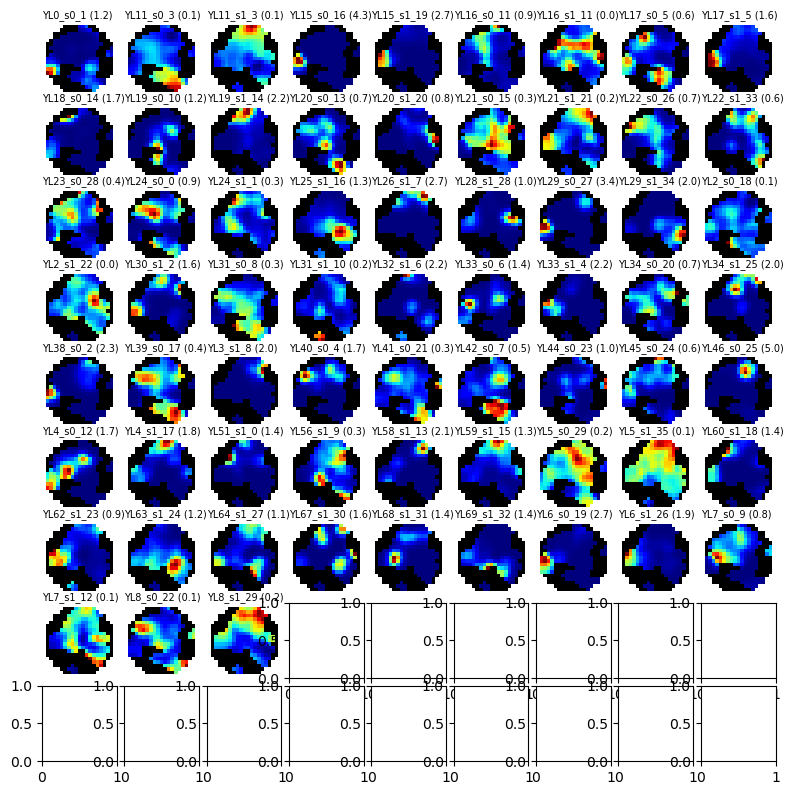

In [26]:
sorted_keys = sorted(AllCellDictSess.keys())
AllCellDictSess = {key: AllCellDictSess[key]for rank, key in enumerate(sorted_keys)}

nb_subplot=min(len(AllCellDictSess.keys()), 100)
rows = int(np.ceil(np.sqrt(nb_subplot)))  # Rows: ceil(sqrt(X))
cols = int(np.ceil(np.sqrt(nb_subplot)))  # Columns: floor(sqrt(X))

# Create the figure with a 2x2 grid
fig, axs = plt.subplots(rows, cols, figsize=(8, 8))
axs = axs.flatten()
plt.tight_layout()

sigma = 1  # Standard deviation for Gaussian kernel
max_row = int(table_radius*2/square_size)
max_col = int(table_radius*2/square_size)

Smoothed_ActSess={}
Smoothed_TimeSess={}
Spatial_infoSess = {}

for nsubplot, nr in enumerate(AllCellDictSess.keys()):

    nr_tot_act = AllCellDictSess[nr]    
    nr_tot_act_array = [[None for _ in range(max_col)] for _ in range(max_row)] # Initialize 2D array
    for (row, col), value in nr_tot_act.items():# Fill array
        nr_tot_act_array[row][col] = value    
    nr_tot_act_array = [[np.nan if v is None else v for v in row] for row in nr_tot_act_array] # Replace None with np.nan
    nr_tot_act_array = np.array(nr_tot_act_array, dtype=float)
    nr_tot_act_array=nr_tot_act_array.T

    array_for_filter = np.nan_to_num(nr_tot_act_array, nan=0.0) # Replace nan with 0 for Gaussian filtering
    act_smoothed_array = gaussian_filter(array_for_filter, sigma=sigma)    # Apply 2D Gaussian filter


    nr_tot_time = AllTimeDictSess[nr]
    nr_tot_time_array = [[None for _ in range(max_col)] for _ in range(max_row)] # Initialize 2D array
    for (row, col), value in nr_tot_time.items():# Fill array
        nr_tot_time_array[row][col] = value
    nr_tot_time_array = [[np.nan if v is None else v for v in row] for row in nr_tot_time_array] # Replace None with np.nan
    nr_tot_time_array = np.array(nr_tot_time_array, dtype=float)
    nr_tot_time_array=nr_tot_time_array.T

    array_for_filter = np.nan_to_num(nr_tot_time_array, nan=0.0) # Replace nan with 0 for Gaussian filtering
    time_smoothed_array = gaussian_filter(array_for_filter, sigma=sigma)    # Apply 2D Gaussian filter
    time_smoothed_array[time_smoothed_array < .5] = np.nan  # do not consider if spent less than 0.1 second in the square

    # Ratio
    act_smoothed_array = np.divide(act_smoothed_array, time_smoothed_array)

    # --- Mask outside circle ---
    rows, cols = act_smoothed_array.shape
    center_row, center_col = rows // 2, cols // 2
    radius = min(rows, cols) // 2   
    Y, X = np.ogrid[:rows, :cols]# Create a circular mask
    dist_from_center = np.sqrt((X - center_col)**2 + (Y - center_row)**2)
    mask = dist_from_center < radius    
    act_smoothed_array_mask = np.where(mask, act_smoothed_array, np.nan)# Apply mask: set values outside circle to NaN
    Smoothed_ActSess[nr]= act_smoothed_array_mask

    time_smoothed_array_mask = np.where(mask, time_smoothed_array, np.nan)# Apply mask: set values outside circle to NaN
    Smoothed_TimeSess[nr]= time_smoothed_array_mask


    # --- Spatial information ---
    mean_act=np.nanmean(Smoothed_ActSess[nr])
    sum_time=np.nansum(Smoothed_TimeSess[nr])
    Spatial_infoSess[nr] = 0
    for rows in np.arange(np.shape(Smoothed_ActSess[nr])[0]) : 
        for cols in np.arange(np.shape(Smoothed_ActSess[nr])[1]) :             
            bin_act=Smoothed_ActSess[nr][rows,cols]
            p_bin=Smoothed_TimeSess[nr][rows,cols]/sum_time 
            if ~ np.isnan(bin_act): 
                if bin_act!=0:             
                    spatial_info_bin=p_bin*(bin_act/mean_act)*math.log2(bin_act/mean_act)
                else:
                    spatial_info_bin=0    
                Spatial_infoSess[nr] += spatial_info_bin


    # Mask outside circle 
    rows, cols = np.full((max_row, max_col),1).shape
    center_row, center_col = rows // 2, cols // 2
    radius = min(rows, cols) // 2   
    Y, X = np.ogrid[:rows, :cols]# Create a circular mask
    dist_from_center = np.sqrt((X - center_col)**2 + (Y - center_row)**2)
    mask = dist_from_center < radius    
    masked_array = np.where(mask, np.full((max_row, max_col),1), np.nan)# Apply mask: set values outside circle to NaN
    
    # Draw map
    axs[nsubplot].imshow(masked_array, cmap='Greys_r', origin='upper')
    axs[nsubplot].imshow(act_smoothed_array_mask, cmap='jet', origin='upper')
    axs[nsubplot].set_aspect('equal')
    axs[nsubplot].set_title(f'{nr} ({np.round(Spatial_infoSess[nr], 1)})', pad=0, loc='left', fontsize=7)

        
    # Remove box (spines)
    for spine in axs[nsubplot].spines.values():
        spine.set_visible(False)
    axs[nsubplot].set_xticks([])  # No x-axis ticks
    axs[nsubplot].set_yticks([])  # No y-axis ticks

# Adjust layout to avoid clipping
fig.subplots_adjust(wspace=.1, hspace=.1)
plt.show()


Plot place map of all unique cells

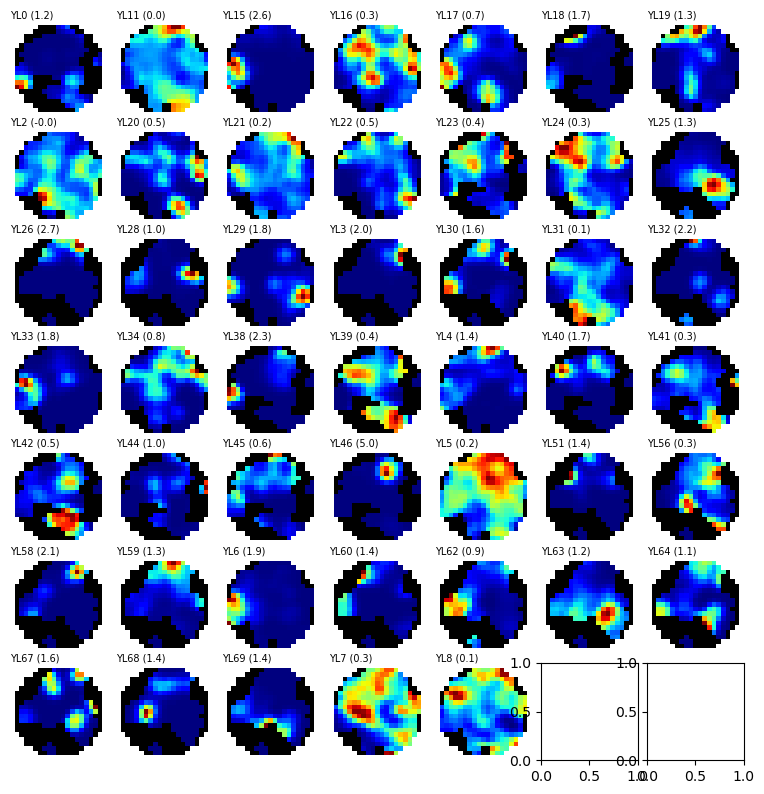

In [11]:
sorted_keys = sorted(SumActDict.keys())
SumActDict = {key: SumActDict[key]for rank, key in enumerate(sorted_keys)}

nb_subplot=min(len(SumActDict.keys()), 100)
rows = int(np.ceil(np.sqrt(nb_subplot)))  # Rows: ceil(sqrt(X))
cols = int(np.ceil(np.sqrt(nb_subplot)))  # Columns: floor(sqrt(X))

# Create the figure with a 2x2 grid
fig, axs = plt.subplots(rows, cols, figsize=(8, 8))
axs = axs.flatten()
plt.tight_layout()

sigma = 1  # Standard deviation for Gaussian kernel
max_row = int(table_radius*2/square_size)
max_col = int(table_radius*2/square_size)

Smoothed_Act={}
Smoothed_Time={}
Spatial_info = {}

for nsubplot, nr in enumerate(SumActDict.keys()):

    nr_tot_act = SumActDict[nr]    
    nr_tot_act_array = [[None for _ in range(max_col)] for _ in range(max_row)] # Initialize 2D array
    for (row, col), value in nr_tot_act.items():# Fill array
        nr_tot_act_array[row][col] = value    
    nr_tot_act_array = [[np.nan if v is None else v for v in row] for row in nr_tot_act_array] # Replace None with np.nan
    nr_tot_act_array = np.array(nr_tot_act_array, dtype=float)
    nr_tot_act_array=nr_tot_act_array.T

    array_for_filter = np.nan_to_num(nr_tot_act_array, nan=0.0) # Replace nan with 0 for Gaussian filtering
    act_smoothed_array = gaussian_filter(array_for_filter, sigma=sigma)    # Apply 2D Gaussian filter


    nr_tot_time = SumTimeDict[nr]
    nr_tot_time_array = [[None for _ in range(max_col)] for _ in range(max_row)] # Initialize 2D array
    for (row, col), value in nr_tot_time.items():# Fill array
        nr_tot_time_array[row][col] = value
    nr_tot_time_array = [[np.nan if v is None else v for v in row] for row in nr_tot_time_array] # Replace None with np.nan
    nr_tot_time_array = np.array(nr_tot_time_array, dtype=float)
    nr_tot_time_array=nr_tot_time_array.T

    array_for_filter = np.nan_to_num(nr_tot_time_array, nan=0.0) # Replace nan with 0 for Gaussian filtering
    time_smoothed_array = gaussian_filter(array_for_filter, sigma=sigma)    # Apply 2D Gaussian filter
    time_smoothed_array[time_smoothed_array < .5] = np.nan  # do not consider if spent less than 0.1 second in the square

    # Ratio
    act_smoothed_array = np.divide(act_smoothed_array, time_smoothed_array)

    # --- Mask outside circle ---
    rows, cols = act_smoothed_array.shape
    center_row, center_col = rows // 2, cols // 2
    radius = min(rows, cols) // 2   
    Y, X = np.ogrid[:rows, :cols]# Create a circular mask
    dist_from_center = np.sqrt((X - center_col)**2 + (Y - center_row)**2)
    mask = dist_from_center < radius    
    act_smoothed_array_mask = np.where(mask, act_smoothed_array, np.nan)# Apply mask: set values outside circle to NaN
    Smoothed_Act[nr]= act_smoothed_array_mask

    time_smoothed_array_mask = np.where(mask, time_smoothed_array, np.nan)# Apply mask: set values outside circle to NaN
    Smoothed_Time[nr]= time_smoothed_array_mask


    # --- Spatial information ---
    mean_act=np.nanmean(Smoothed_Act[nr])
    sum_time=np.nansum(Smoothed_Time[nr])
    Spatial_info[nr] = 0
    for rows in np.arange(np.shape(Smoothed_Act[nr])[0]) : 
        for cols in np.arange(np.shape(Smoothed_Act[nr])[1]) :             
            bin_act=Smoothed_Act[nr][rows,cols]
            p_bin=Smoothed_Time[nr][rows,cols]/sum_time 
            if ~ np.isnan(bin_act): 
                if bin_act!=0:             
                    spatial_info_bin=p_bin*(bin_act/mean_act)*math.log2(bin_act/mean_act)
                else:
                    spatial_info_bin=0    
                Spatial_info[nr] += spatial_info_bin


    # Mask outside circle 
    rows, cols = np.full((max_row, max_col),1).shape
    center_row, center_col = rows // 2, cols // 2
    radius = min(rows, cols) // 2   
    Y, X = np.ogrid[:rows, :cols]# Create a circular mask
    dist_from_center = np.sqrt((X - center_col)**2 + (Y - center_row)**2)
    mask = dist_from_center < radius    
    masked_array = np.where(mask, np.full((max_row, max_col),1), np.nan)# Apply mask: set values outside circle to NaN
    
    # Draw map
    axs[nsubplot].imshow(masked_array, cmap='Greys_r', origin='upper')
    axs[nsubplot].imshow(act_smoothed_array_mask, cmap='jet', origin='upper')
    axs[nsubplot].set_aspect('equal')
    axs[nsubplot].set_title(f'{nr} ({np.round(Spatial_info[nr], 1)})', pad=0, loc='left', fontsize=7)

        
    # Remove box (spines)
    for spine in axs[nsubplot].spines.values():
        spine.set_visible(False)
    axs[nsubplot].set_xticks([])  # No x-axis ticks
    axs[nsubplot].set_yticks([])  # No y-axis ticks

# Adjust layout to avoid clipping
fig.subplots_adjust(wspace=.1, hspace=.1)
plt.show()


Run permutation tests on circularly shifted calcium traces

In [ ]:
ShuffledSpatial_info={}
for nr in SumActDict.keys():
    ShuffledSpatial_info[nr]={}

nb_tot_permutation=1000
for permutation_nb in range(nb_tot_permutation):

    AllCellDict={}
    AllTimeDict={}
    AllCellDictSess={}
    AllTimeDictSess={}

    for dpath in Path(dir).glob('**/mappingsAB.pkl'):

        mappfile = open(dpath.parents[0]/ f'mappingsAB.pkl', 'rb')
        mapping = pickle.load(mappfile)
        mapping_sess = mapping['session']   
            
        centfile = open(dpath.parents[0]/ f'centsAB.pkl', 'rb')
        centroids = pickle.load(centfile) 

        mice = dpath.parents[1].parts[-1]
        NeuronType = dpath.parents[2].parts[-1]

        nb_minian_total=0
        dict_Path={}
        dict_Calcium = {}
        dict_MousePosition = {}
        dict_TodropFile = {}
        dict_StampsMiniscope = {}

        minian_folders = [f for f in dpath.parents[0].rglob('minian') if f.is_dir()]

        for sess, minianpath in enumerate(minian_folders): # for each minian folders found in this mouse 

            if any(p in all_expe_types for p in minianpath.parts): # have to be to the expe_types

                session_type=minianpath.parents[2].name
                session_date=minianpath.parents[3].name
                session_time=minianpath.parents[1].name
                session=session_time
                session_path=minianpath.parents[1] 
                dict_Path[session] = session_path

                # Minian data
                
                minian_ds = open_minian(minianpath)
                Co = minian_ds['C']  # calcium traces
                tsmini= pd.read_csv(list(session_path.glob('*V4_Miniscope/timeStamps.csv'))[0])['Time Stamp (ms)']
                minian_freq=round(1/np.mean(np.diff(np.array(tsmini)/1000)))
                dict_StampsMiniscope[session] =tsmini
                try: 
                    TodropFile = minianpath / f'TodropFileAB.json'
                    with open(TodropFile, 'r') as f:
                        unit_to_drop = json.load(f)
                except:
                    TodropFile = minianpath.parent / f'TodropFileAB.json'
                    with open(TodropFile, 'r') as f:
                        unit_to_drop = json.load(f)


                # DeepLabCut data

                dlcfile=''
                dlcpath=Path(f'{Path(session_path)}/My_First_WebCam/')
                for file in os.listdir(dlcpath):
                    if file.endswith(('.h5')):
                        dlcfile=file
                        break
                dlc_path = os.path.join(dlcpath, dlcfile)
                df = pd.read_hdf(dlc_path)
                directory = os.path.dirname(dlc_path)
                timestamps_path = Path(directory,'timeStamps.csv')
                if timestamps_path.exists():
                    timestamps = pd.read_csv(timestamps_path)
                    tswebcam = np.array(timestamps['Time Stamp (ms)'])
                    frame_rate = round(1/(np.mean(np.diff(timestamps.iloc[:,1]))/1000))  # fps
                else:
                    frame_rate = 16  # fps /!\ CHANGE ACCORDING TO YOUR DATA
                df.iloc[:, 0] = df.apply(lambda row: row.iloc[0] if row.iloc[2] > 0.5 else np.nan, axis=1)
                df.iloc[:, 1] = df.apply(lambda row: row.iloc[1] if row.iloc[2] > 0.5 else np.nan, axis=1)
                X = df.iloc[:, 0]
                Y = df.iloc[:, 1]        
                individual_xO= np.array(X.values) 
                individual_yO = np.array(Y.values)
                for i, x in enumerate(individual_xO):# Define when the mouse is on the cheeseboard (start)
                    y = individual_yO[i]
                    if calculate_relative_distance(x, y, table_center_x, table_center_y) >= table_radius:
                        individual_xO[i] = np.nan
                        individual_yO[i] = np.nan
                individual_xOO = remove_short_sequences(individual_xO, max_len=3)
                individual_yOO = remove_short_sequences(individual_yO, max_len=3)
                x_start = find_long_non_nan_sequences(individual_xOO)[0][0] # first value of the first long non nan sequence
                y_start = find_long_non_nan_sequences(individual_yOO)[0][0] # first value of the first long non nan sequence
                start_frame = np.where(individual_xOO == x_start)[0][0].item()
                individual_xOO[:start_frame]=np.nan # remove any path before the real start
                individual_yOO[:start_frame]=np.nan # remove any path before the real start
                individual_x1, individual_y1 = replace_high_speed_points_with_nan(individual_xOO, individual_yOO, speed_threshold=10)
                last_frame = len(individual_x1)
                individual_x2, individual_y2 = interpolate_2d_path(individual_x1[start_frame:last_frame], individual_y1[start_frame:last_frame], kind='nearest')
                individual_x3, individual_y3 = limit_speed(individual_x2, individual_y2, max_speed=20)
                individual_x = np.concatenate((individual_x1[:start_frame], individual_x3))
                individual_y = np.concatenate((individual_y1[:start_frame], individual_y3))
                dict_MousePosition[session] = pd.DataFrame({'x': individual_x, 'y': individual_y})
                

                # Keep only crossregistered cells

                C_sel=Co.drop_sel(unit_id=unit_to_drop)
                indexMappList=mapping_sess[session]
                kept_uniq_unit_List=[]
                for unit in C_sel['unit_id'].values:
                    indexMapp = np.where(indexMappList == unit)[0]
                    kept_uniq_unit_List.append(str(indexMapp))
                nb_unit=len(C_sel['unit_id'].values)
                if nb_unit==0:
                    continue

                # Align data

                start_time = timestamps.iloc[start_frame,1].item() / 1000
                end_time = timestamps.iloc[-1,1].item() / 1000
                closest_start= find_closest_index_sorted(tsmini, start_time*1000)
                closest_end= find_closest_index_sorted(tsmini, end_time*1000)
                x= individual_x[start_frame:last_frame]
                y= individual_y[start_frame:last_frame]
                Carray = C_sel[:, closest_start:closest_end+1].to_numpy().T

                
                # Randomly shift the calcium trace to break temporal correlation with behavior
                offset = random.randint(20*minian_freq, len(Carray)) # Random shift between 20s and the length of the session
                Carray = np.roll(Carray, shift=offset, axis=0) 


                Calcium = pd.DataFrame(Carray.T, index=C_sel['unit_id'].values.tolist())            
                dict_Calcium[session] = Calcium


                # Keep only crossregistered cells
                
                n = int(np.floor(2 * table_radius / square_size))
                for unit in range(nb_unit): 
                    indexMapp = np.where(mapping_sess[session] == Calcium.index[unit])[0]
                    if len(indexMapp)>0 : # The neuron needs to be in the cross-registration
                        unique_unit = f'{mice}{str(indexMapp[0])}'
                        sess_unit = f'{mice}{str(indexMapp[0])}_s{sess}_{unit}'
                        Carray_unit = Carray[:,unit]
                        nr_tot_act_biaised = defaultdict(int) # Neuron activity per square
                        counts = defaultdict(int) # Count visits per square
                        for idx, (px, py) in enumerate(zip(x, y)):
                            if np.sqrt((px - table_center_x)**2 + (py - table_center_y)**2) > table_radius:
                                continue  # skip points outside circle
                            ix = int(np.floor((px - (table_center_x - n/2 * square_size)) / square_size))
                            iy = int(np.floor((py - (table_center_y - n/2 * square_size)) / square_size))
                            closest_point= find_closest_index_sorted(tsmini, tswebcam[start_frame+idx])
                            nr_tot_act_biaised[(ix, iy)] += Carray_unit[closest_point]
                            counts[(ix, iy)] += 1/frame_rate 

                        if unique_unit in AllCellDict:
                            AllCellDict[unique_unit][session] = nr_tot_act_biaised 
                            AllTimeDict[unique_unit][session] = counts
                        else :
                            AllCellDict[unique_unit] = {}
                            AllCellDict[unique_unit][session] = nr_tot_act_biaised 
                            AllTimeDict[unique_unit] = {}
                            AllTimeDict[unique_unit][session] = counts

                        AllCellDictSess[sess_unit] = nr_tot_act_biaised 
                        AllTimeDictSess[sess_unit] = counts

                nb_minian_total+=1
        
    #########################################################################################
                    # Average activity map across sessions for each cell #
    ##########################################################################################

    SumActDict={}
    for uniquecell in AllCellDict.keys():
        sums = {}
        for subdict in AllCellDict[uniquecell].values():
            for key, value in subdict.items():
                sums[key] = sums.get(key, 0) + value
        SumActDict[uniquecell] = {key: sums[key] for key in sums}

    SumTimeDict={}
    for uniquecell in AllTimeDict.keys():
        sums = {}
        for subdict in AllTimeDict[uniquecell].values():
            for key, value in subdict.items():
                sums[key] = sums.get(key, 0) + value
        SumTimeDict[uniquecell] = {key: sums[key] for key in sums}


    sorted_keys = sorted(SumActDict.keys())
    SumActDict = {key: SumActDict[key]for rank, key in enumerate(sorted_keys)}

    sigma = 1  # Standard deviation for Gaussian kernel
    max_row = int(table_radius*2/square_size)
    max_col = int(table_radius*2/square_size)

    Smoothed_Act={}
    Smoothed_Time={}

    for nsubplot, nr in enumerate(SumActDict.keys()):

        nr_tot_act = SumActDict[nr]    
        nr_tot_act_array = [[None for _ in range(max_col)] for _ in range(max_row)] # Initialize 2D array
        for (row, col), value in nr_tot_act.items():# Fill array
            nr_tot_act_array[row][col] = value    
        nr_tot_act_array = [[np.nan if v is None else v for v in row] for row in nr_tot_act_array] # Replace None with np.nan
        nr_tot_act_array = np.array(nr_tot_act_array, dtype=float)
        nr_tot_act_array=nr_tot_act_array.T

        array_for_filter = np.nan_to_num(nr_tot_act_array, nan=0.0) # Replace nan with 0 for Gaussian filtering
        act_smoothed_array = gaussian_filter(array_for_filter, sigma=sigma)    # Apply 2D Gaussian filter


        nr_tot_time = SumTimeDict[nr]
        nr_tot_time_array = [[None for _ in range(max_col)] for _ in range(max_row)] # Initialize 2D array
        for (row, col), value in nr_tot_time.items():# Fill array
            nr_tot_time_array[row][col] = value
        nr_tot_time_array = [[np.nan if v is None else v for v in row] for row in nr_tot_time_array] # Replace None with np.nan
        nr_tot_time_array = np.array(nr_tot_time_array, dtype=float)
        nr_tot_time_array=nr_tot_time_array.T

        array_for_filter = np.nan_to_num(nr_tot_time_array, nan=0.0) # Replace nan with 0 for Gaussian filtering
        time_smoothed_array = gaussian_filter(array_for_filter, sigma=sigma)    # Apply 2D Gaussian filter
        time_smoothed_array[time_smoothed_array < .5] = np.nan  # do not consider if spent less than 0.1 second in the square

        # Ratio
        act_smoothed_array = np.divide(act_smoothed_array, time_smoothed_array)

        # --- Mask outside circle ---
        rows, cols = act_smoothed_array.shape
        center_row, center_col = rows // 2, cols // 2
        radius = min(rows, cols) // 2   
        Y, X = np.ogrid[:rows, :cols]# Create a circular mask
        dist_from_center = np.sqrt((X - center_col)**2 + (Y - center_row)**2)
        mask = dist_from_center < radius    
        act_smoothed_array_mask = np.where(mask, act_smoothed_array, np.nan)# Apply mask: set values outside circle to NaN
        Smoothed_Act[nr]= act_smoothed_array_mask

        time_smoothed_array_mask = np.where(mask, time_smoothed_array, np.nan)# Apply mask: set values outside circle to NaN
        Smoothed_Time[nr]= time_smoothed_array_mask


        # --- Spatial information ---
        mean_act=np.nanmean(Smoothed_Act[nr])
        sum_time=np.nansum(Smoothed_Time[nr])

        ShuffledSpatial_info[nr][permutation_nb] = 0

        for rows in np.arange(np.shape(Smoothed_Act[nr])[0]) : 
            for cols in np.arange(np.shape(Smoothed_Act[nr])[1]) :             
                bin_act=Smoothed_Act[nr][rows,cols]
                p_bin=Smoothed_Time[nr][rows,cols]/sum_time 
                if ~ np.isnan(bin_act): 
                    if bin_act!=0:             
                        spatial_info_bin=p_bin*(bin_act/mean_act)*math.log2(bin_act/mean_act)
                    else:
                        spatial_info_bin=0 

                    ShuffledSpatial_info[nr][permutation_nb] += spatial_info_bin

    print(f'Permutation n° {permutation_nb} done')  

#sys.stdout = sys.__stdout__
#logfile.close()

Permutation n° 0 done
Permutation n° 1 done
Permutation n° 2 done
Permutation n° 3 done
Permutation n° 4 done
Permutation n° 5 done
Permutation n° 6 done
Permutation n° 7 done
Permutation n° 8 done
Permutation n° 9 done
Permutation n° 10 done
Permutation n° 11 done
Permutation n° 12 done
Permutation n° 13 done
Permutation n° 14 done
Permutation n° 15 done
Permutation n° 16 done
Permutation n° 17 done
Permutation n° 18 done
Permutation n° 19 done
Permutation n° 20 done
Permutation n° 21 done
Permutation n° 22 done
Permutation n° 23 done
Permutation n° 24 done
Permutation n° 25 done
Permutation n° 26 done
Permutation n° 27 done
Permutation n° 28 done
Permutation n° 29 done
Permutation n° 30 done
Permutation n° 31 done
Permutation n° 32 done
Permutation n° 33 done
Permutation n° 34 done
Permutation n° 35 done
Permutation n° 36 done
Permutation n° 37 done
Permutation n° 38 done
Permutation n° 39 done
Permutation n° 40 done
Permutation n° 41 done
Permutation n° 42 done
Permutation n° 43 don

YL_15, YL_33 & YL_6 should be a place cell

In [65]:
sorted_keys = sorted(ShuffledSpatial_info.keys())
ShuffledSpatial_info = {key: ShuffledSpatial_info[key] for rank, key in enumerate(sorted_keys)}
nb_tot_permutation = 1000
for nr in ShuffledSpatial_info.keys():
    count_higher=0
    for permutation_nb in range(nb_tot_permutation):
        if ShuffledSpatial_info[nr][permutation_nb]>=Spatial_info[nr]:
            count_higher+=1
    p_value=(count_higher+1)/(nb_tot_permutation+1) # +1 for the observed value, +1 for the total number of shuffling
    
    if p_value<0.05:
        print(f'{nr} is a place cell ! p_value = {np.round(p_value,2)} (spatial info = {np.round(Spatial_info[nr], 1)})')

YL25 is a place cell ! p_value = 0.01 (spatial info = 1.3)
YL29 is a place cell ! p_value = 0.0 (spatial info = 1.8)
YL46 is a place cell ! p_value = 0.01 (spatial info = 5.0)
YL5 is a place cell ! p_value = 0.01 (spatial info = 0.2)
YL63 is a place cell ! p_value = 0.0 (spatial info = 1.2)


In [66]:
sorted_keys = sorted(ShuffledSpatial_info.keys())
ShuffledSpatial_info = {key: ShuffledSpatial_info[key] for rank, key in enumerate(sorted_keys)}

for nr in ShuffledSpatial_info.keys():
    count_higher=0
    for permutation_nb in range(nb_tot_permutation):
        if ShuffledSpatial_info[nr][permutation_nb]>=Spatial_info[nr]:
            count_higher+=1
    p_value=(count_higher+1)/(nb_tot_permutation+1) # +1 for the observed value, +1 for the total number of shuffling
    print(f'{nr} : p_value = {np.round(p_value,2)} (spatial info = {np.round(Spatial_info[nr], 1)})')

YL0 : p_value = 0.19 (spatial info = 1.2)
YL11 : p_value = 0.78 (spatial info = 0.0)
YL15 : p_value = 0.17 (spatial info = 2.6)
YL16 : p_value = 0.61 (spatial info = 0.3)
YL17 : p_value = 0.26 (spatial info = 0.7)
YL18 : p_value = 0.44 (spatial info = 1.7)
YL19 : p_value = 0.35 (spatial info = 1.3)
YL2 : p_value = 0.95 (spatial info = -0.0)
YL20 : p_value = 0.8 (spatial info = 0.5)
YL21 : p_value = 0.22 (spatial info = 0.2)
YL22 : p_value = 0.62 (spatial info = 0.5)
YL23 : p_value = 0.41 (spatial info = 0.4)
YL24 : p_value = 0.68 (spatial info = 0.3)
YL25 : p_value = 0.01 (spatial info = 1.3)
YL26 : p_value = 0.09 (spatial info = 2.7)
YL28 : p_value = 0.9 (spatial info = 1.0)
YL29 : p_value = 0.0 (spatial info = 1.8)
YL3 : p_value = 0.63 (spatial info = 2.0)
YL30 : p_value = 0.15 (spatial info = 1.6)
YL31 : p_value = 0.81 (spatial info = 0.1)
YL32 : p_value = 0.15 (spatial info = 2.2)
YL33 : p_value = 0.15 (spatial info = 1.8)
YL34 : p_value = 0.35 (spatial info = 0.8)
YL38 : p_value =